# Data Science en pratique

Arthur Llau, mail : arthur@flowlity.com

# Pensez à m'envoyer vos CV avant le 24/10

# Cours 3 : Feature Engineering II

## Objectif du cours : Création de features, transformations & sampling
- Comment scaler les données
- Apporter des techniques de création de features et de nettoyage des données
- Essayer de résoudre les problèmes de déséquilibre des variables cibles

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import load_breast_cancer, load_boston

import warnings
warnings.filterwarnings('ignore')
data = load_breast_cancer()['data']
target = load_breast_cancer()['target']
plt.rcParams['figure.figsize'] = (10,5)
plt.rcParams['figure.figsize'] = (10,5)

## I - Scaling & Standardisation

On a parfois besoin de normaliser ou standardiser les données pour pouvoir les utiliser avec certains algorithmes. Typiquement les SVM (pas invariant par transformation affine) ont pour hypothèse que les données sont centrées autour de 0 et possèdent une variance de même ordre. Si une variable à une variance plus elevée que les autres la fonction objectif peut être alors biaisée et ne pas correctement apprendre les autres variables.
Un autre cas : la descente de gradient converge beaucoup plus rapidemment avec des valeurs normalisées.

En général c'est obligatoire si il y a une distance dans l'histoire. Pas obligatoire avec les arbres qui sont invariants par transformation affine.

** Min Max Scaling **

Revient à normaliser les données dans l'intervalle [0,1] :

$$x'={\frac {x-{\text{min}}(x)}{{\text{max}}(x)-{\text{min}}(x)}}$$


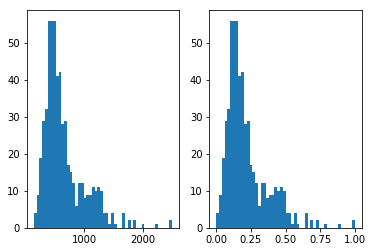

In [2]:
from sklearn.preprocessing import minmax_scale

plt.subplot(121)
plt.hist(data[:,3], bins = 50);
plt.subplot(122)
plt.hist(minmax_scale(data[:,3]), bins = 50);

** Mean Max Scaling **

Revient à normaliser les données dans l'intervalle [-1,1] :

$$x'={\frac {x-{\text{mean}}(x)}{{\text{max}}(x)-{\text{min}}(x)}}$$


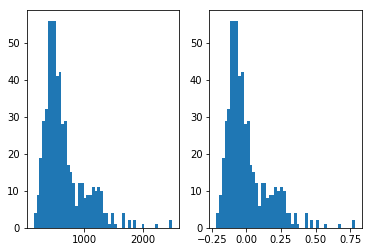

In [3]:
X = data[:,3]
X_std = (X - X.mean(axis=0)) / (X.max(axis=0) - X.min(axis=0))

plt.subplot(121)
plt.hist(X, bins = 50);
plt.subplot(122)
plt.hist(X_std, bins = 50);

** Standardisation **

Grand classique : 

$$ x' = \frac{x - \bar{x}}{\sigma} $$

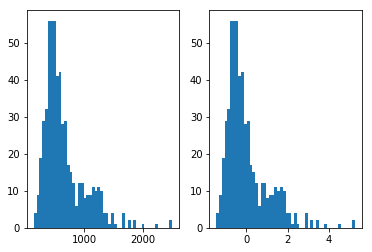

In [4]:
from sklearn.preprocessing import scale

plt.subplot(121)
plt.hist(data[:,3], bins = 50);
plt.subplot(122)
plt.hist(scale(data[:,3]), bins = 50);

## II - Transformations 



** Power Transformations **


C'est une famille de transformation qui permettent de stabiliser la variance d'une distribution.
Les transformations à la puissance change la distribution de la variable pour quelle ne soit plus dépendante de la moyenne. (voir Loi de Poisson par ex).

On trouve plusieurs transformation de ce type, comme le log ou la transformée de Box-Cox chacune ayant leur propre spécifité.


$$ {\displaystyle B(x,\lambda )={\begin{cases}{\frac {x^{\lambda }-1}{\lambda }}&{\text{si }}\lambda \neq 0\\\log(x)&{\text{si }}\lambda =0\end{cases}}} $$


La transformation par le log permet de transformer une distribution avec une queue lourde en une distribution avec des queues plus légères. C'est-à-dire que cette méthode compresse les grands écarts et disperse les petits écarts entre les valeurs.

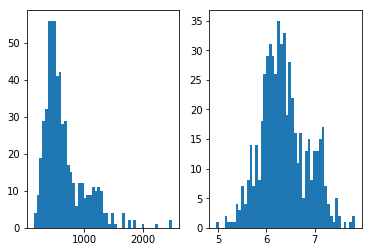

In [5]:
plt.subplot(121)
plt.hist(data[:,3], bins = 50);
plt.subplot(122)
plt.hist(np.log(data[:,3]), bins = 50);

Autre cas où c'est utile : on est très concentré autour de 0 mais les écarts sont difficiles à visualiser.

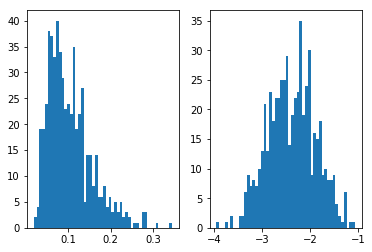

In [6]:
plt.subplot(121)
plt.hist(data[:,5], bins = 50);
plt.subplot(122)
plt.hist(np.log(data[:,5]), bins = 50);

** Lissage, réduction de bruit **

Lorsque nos données proviennent de signaux on retrouve régulièrement un bruit, dû par exemple aux capteurs. Une bonne méthode de préprocessing des données des signaux est donc de supprimer ce bruit, c'est-à-dire lisser les signaux, pour cela la littérature régorge de méthodes :
- Lissage par moyenne glissante
- Les splines de lissage
- Lissage par noyaux
- Filtre de Kalman
- Savitzky-Golay
- Douglas-Peucker


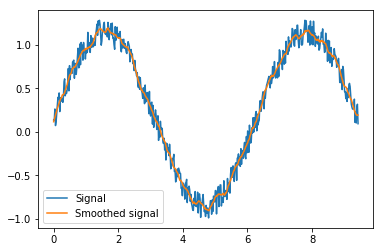

In [7]:
from scipy.signal import savgol_filter

x = np.linspace(0,3*np.pi, 500)
y = np.sin(x)+np.random.rand(500)*0.3

plt.plot(x, y, label = 'Signal')
plt.plot(x, savgol_filter(y,23,3), label = 'Smoothed signal')
plt.legend()

Attention, selon l'algorithme utilisé, il existe un paramètre de lissage à calibrer pour ne pas surlisser ou bien sous lisser. (Et oui, on fait de l'apprentissage en fait)


## III - Features inputing

À partir des données on peut constuire plusieurs types de nouvelles variables :
-  des variables arithmétiques, polynomiales
-  des variables issues de statistiques
-  des features provenant des expertises métier (ratio, interactions)
-  des résultats de non-supervisé
-  des lags si on a des données temporelles
-  du mean target encoding

Comme exemple, on reprend le jeu de données du dernier cours (les vélos).

In [8]:
data = pd.read_csv('../Cours 2/train.csv')

** Statistiques **

Il est évident que l'on peut construire des features comme des statistiques provenant des observations.
Par exemple, on peut construire la moyenne d'une observation par rapport à une catégorie. On peut dans notre cas choisir d'observer la température moyenne par condition météorologique.


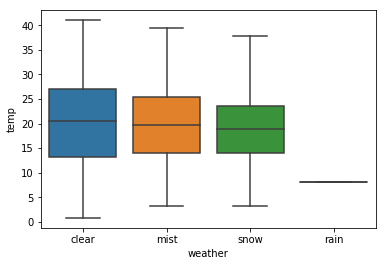

In [9]:
sns.boxplot(x='weather', y = 'temp', data = data); # On peut le maper comme une nouvelle variable !

In [10]:
gp = data.groupby('weather')['temp']
print (gp.mean())

mean = gp.mean()
std  = gp.std()
data['weath_tmp_avg'] = data['weather'].map(mean)
data['weath_tmp_std'] = data['weather'].map(std)
data.head()

weather
clear    20.256703
mist     19.403129
rain      8.200000
snow     18.931304
Name: temp, dtype: float64


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,weath_tmp_avg,weath_tmp_std
0,2011-01-01 00:00:00,winter,0,0,clear,9.84,14.395,81,5.18,16,20.256703,8.339352
1,2011-01-01 01:00:00,NaN,0,0,clear,9.02,13.635,80,NaN,40,20.256703,8.339352
2,2011-01-01 02:00:00,NaN,0,0,clear,9.02,13.635,80,6.32,32,20.256703,8.339352
3,2011-01-01 03:00:00,winter,0,0,clear,9.84,14.395,75,NaN,13,20.256703,8.339352
4,2011-01-01 04:00:00,winter,0,0,clear,9.84,14.395,75,NaN,1,20.256703,8.339352


** Features Polynomiaux **

Les features polynomiaux sont simplement des interactions, selon le binôme de Newton, des variables du jeux de données :

A l'ordre 2 :
    [a,b] - > [1,a,b,ab,a²,b²]
    
C'est utile si on ne sait pas trop où chercher et si les données sont anonymisées.
Deux inconvénients majeurs si le degré est grand: 
- Le nombre de features explose
- Les observations créées peuvent ne pas tenir en mémoire.


In [11]:
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2)
poly.fit_transform([[2,3]])

array([[1., 2., 3., 4., 6., 9.]])

**Lags**

Cela revient à construire une variable comme étant la target au temps n-1 (ou autre).
Très efficace avec les modèles classiques de séries temporelle, ainsi qu'avec les LSTM, GRU et NeuralNet Autoregressif.



In [12]:
data['lag1'] = data['count'].shift(1)
data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,weath_tmp_avg,weath_tmp_std,lag1
0,2011-01-01 00:00:00,winter,0,0,clear,9.84,14.395,81,5.18,16,20.256703,8.339352,NaN
1,2011-01-01 01:00:00,NaN,0,0,clear,9.02,13.635,80,NaN,40,20.256703,8.339352,16.0
2,2011-01-01 02:00:00,NaN,0,0,clear,9.02,13.635,80,6.32,32,20.256703,8.339352,40.0
3,2011-01-01 03:00:00,winter,0,0,clear,9.84,14.395,75,NaN,13,20.256703,8.339352,32.0
4,2011-01-01 04:00:00,winter,0,0,clear,9.84,14.395,75,NaN,1,20.256703,8.339352,13.0


In [13]:
data['lag2'] = data['count'].shift(2)
data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,weath_tmp_avg,weath_tmp_std,lag1,lag2
0,2011-01-01 00:00:00,winter,0,0,clear,9.84,14.395,81,5.18,16,20.256703,8.339352,NaN,NaN
1,2011-01-01 01:00:00,NaN,0,0,clear,9.02,13.635,80,NaN,40,20.256703,8.339352,16.0,NaN
2,2011-01-01 02:00:00,NaN,0,0,clear,9.02,13.635,80,6.32,32,20.256703,8.339352,40.0,16.0
3,2011-01-01 03:00:00,winter,0,0,clear,9.84,14.395,75,NaN,13,20.256703,8.339352,32.0,40.0
4,2011-01-01 04:00:00,winter,0,0,clear,9.84,14.395,75,NaN,1,20.256703,8.339352,13.0,32.0


** Non supervisé **

On connait diverses méthodes d'apprentissage non-supervisé permettant, entre autres, de faire du clustering.
Il peut être intéressant de construire une nouvelle variable issue d'une de ces méthodes.
Par exemple, pour le jeu de données sur le prix des maisons, ne peut-on pas identifier des clusters de maison ?

Evidemment, il est difficile d'identifier le nombre de clusters simplement, on peut alors procéder de plusieurs méthodes :
-  Chercher le k optimal grâce à de la validation croisée et une fonction silhouette
-  Utiliser un algorithme type dbscan

Il est également possible d'utiliser des méthodes de hiérarchisation pour apporter à chaque observation un rang d'importance.

** Target Mapping **

Le target mapping, ou mean target encoding, est une méthode qui consiste à construire une variable dépendant des targets observées dans le jeu d'apprentissage. On va par exemple, pour une catégorie, prend la moyenne de la variable cible.


In [14]:
gp = data.groupby(['weather','season'])['count']
print (gp.mean())

mean = gp.mean()
means = mean.reset_index(level=['weather','season']).rename(columns={'count':'weather_season_count'})
data = pd.merge(data,means, on = ['weather','season'])
data.head()

weather  season
clear    autumn    160.932718
         spring    236.756402
         summer    212.477640
         winter    127.229979
mist     autumn    149.740741
         spring    191.898625
         summer    193.990654
         winter    105.375817
rain     winter    164.000000
snow     autumn     95.366972
         spring    124.055249
         summer    138.864407
         winter     61.194286
Name: count, dtype: float64


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count,weath_tmp_avg,weath_tmp_std,lag1,lag2,weather_season_count
0,2011-01-01 00:00:00,winter,0,0,clear,9.84,14.395,81,5.18,16,20.256703,8.339352,NaN,NaN,127.229979
1,2011-01-01 03:00:00,winter,0,0,clear,9.84,14.395,75,NaN,13,20.256703,8.339352,32.0,40.0,127.229979
2,2011-01-01 04:00:00,winter,0,0,clear,9.84,14.395,75,NaN,1,20.256703,8.339352,13.0,32.0,127.229979
3,2011-01-01 06:00:00,winter,0,0,clear,9.02,13.635,80,NaN,2,20.256703,8.339352,1.0,1.0,127.229979
4,2011-01-01 07:00:00,winter,0,0,clear,8.20,12.880,86,NaN,3,20.256703,8.339352,2.0,1.0,127.229979


Et surtout, on réfléchit !!

## IV - Réduction de dimension

Vous verrez plusieurs méthodes d'apprentissage non-supervisé pour permettre des réductions de dimensions, c'est-à-dire passer d'un espace très grand de variables décorrélées à un espace plus petit de variables corrélées. 
Vous trouverez les méthodes suivantes :
- Principal Component Analysis (PCA)
- Non-negative Matrix Factorization (NMF)
- Kernel-PCA
- Fast Independant Component Analysis (Fast ICA)
- AutoEncoder
- t-distribued stochastic neighbor embedding (t-SNE)

Ces méthodes permettent de réduire grandement le nombre de variable, ce qui est en cas de fléau de la dimension peut s'avérer très efficace (voir le kaggle [Mercedes](https://www.kaggle.com/c/mercedes-benz-greener-manufacturing).

## V - Resampling & Synthetic sampling

Une problématique de l'apprentissage statistique concerne les jeux de données avec une variable cible déséquilibrée à classifier. 
C'est un problème car la plupart des algorithmes vont apprendre surtout à prédire la valeur qu'ils observent le plus et alors mal prédire la valeur peu représentée.
Intuitivement, on dispose alors de deux techniques pour équilibré les données :
- L'upsampling
- Le downsampling

Il existe évidemment une littérature très développée autour de ces techniques avec différents algorithmes, nous en verrons quelques exemples. 

_Un bon [kernel](https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets) explicatif._

** Metric Trap **

La métrique utilisée peut être totalement à l'ouest si la variable cible est déséquilibrée.

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification

X,y = make_classification(600, weights = [99/100., 1./100], random_state = 123)

model = LogisticRegression()
model.fit(X[:500],y[:500])

print('Performance d\'une regression logistique : {}'.format(accuracy_score(y[500:],model.predict(X[500:]))))
print('Performance d\'un vecteur nul : {}'.format(accuracy_score(y[500:],np.zeros((100,1)))))


Performance d'une regression logistique : 0.98
Performance d'un vecteur nul : 0.98


Métrique invariante pour ce genre de problème : roc auc, F1, matrice de confusion ...

![exemple](resampling.png)

La technique à utiliser dépend généralement du nombre d'observations et des données.

** Downsampling de la majorité **

On peut tout simplement supprimer des observations trop redondantes pour parvenir à un équilibre dans nos données. Néanmoins, si le volume de données est trop important, il est également possible de choisir aléatoire des observations et de les retirer du jeu d'apprentissage.

**Upsampling de la minorité**

La méthode la plus naïve consiste à construire de nouvelle observation comme un échantillon d'un bootstrap effectué sur chaque variable des observations issues de la minorité. C'est très mauvais si il y a une corrélation entre les variables.

Une bonne solution consiste alors à créér des observations synthétique, pour cela deux méthodes que je vous invite à lire :
- sMOTE : Synthetic Minority Oversampling Technique (A partir d'une observation, on observe les k-plus proche voisin et on construit une nouvelle observation synthétique proche de la première)
- ADAWYN : the Adatptive Synthetic sampling method


# TP - Mise en pratique

In [16]:
import os
import numpy as  np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (10,10)

**0** - Question préliminaire : importer les données, quel type de problème est-ce ?

In [17]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

**1** Exploratory Data Analysis

**1.1** - Observez les données, quel type de variables trouve-t-on ? Des valeurs manquantes ?

In [1]:
def Missing_values(data):
    total = data.isnull().sum().sort_values(ascending=False)
    percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total,percent], axis=1, keys=['Total', 'Pourcentage'])
    print( missing_data[(percent>0)],'\n' )

**1.2** - Quels sont les variables catégorielles ? Combien trouve-t'on d'éléments unique par variable? 


**1.3** -Extrayez les variables catégorielle de type object dans une list nommée cat_object_features

**1.4** - Visualisez les variables cibles, y-a t'il quelque chose qui vous semble problématique ?

**1.5** - Effectuez un peu de visualisation, que pensez-vous des distributions associées aux variables ?


**1.6** - Quelles variables semblent influées sur la variables cible ?

**2** Feature Engineering & Evaluation des performances

**2.1** - Compléter les valeurs manquantes

**2.2** - Effectuer une copie de vos jeux de données et transformer les variables catégorielles comme bon vous semble. Puis extrayez les variables cibles et supprimer la variable inutile.

In [30]:
from sklearn.preprocessing import LabelEncoder

In [31]:
new_train = train.copy()
new_test = test.copy()

**2.3** - La métrique d'évaluation du problème est l'erreur roc auc. Evaluez deux modèles (Régression Logistique et SVM, par exemple) sur le jeu où vous avez transformer les variables catégorielles.

In [33]:
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression


In [34]:
model_logit = LogisticRegression()
model_svm = SVC(probability=True)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

In [1]:
# fit les modèle et regarder la méthode: model.predict_proba()

**2.4** - Que pourrait on construire comme variables apportant de l'information et permettant d'expliquer mieux les variables cibles ?

**2.5** - Construisez en certaines ! Help : Concatenez les datasets comme un unique dataframe pour effectuer les transformations.


**2.6** - Optez pour une stratégie intelligente pour transformer les variables catégorielles. En oubliant pas de découper le jeu concaténé sur lequel vous avez construit les features.

**2.7** - Observez de nouveau les corrélations. Que constatez vous ?

**2.8** - Evaluez vos deux modèles sur ces nouvelles données - en oubliant pas de supprimer les targets et ID, qu'observez-vous ?

